In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import collections
from tsfresh import extract_features

Using TensorFlow backend.


In [2]:
dfTrainData = pd.read_csv("training_set.csv")
dfMetaData = pd.read_csv("training_set_metadata.csv")
dfPoly = pd.read_csv("polynomial_coefficients_train.csv")
dfBaseline = dfMetaData.drop(["distmod","object_id"],axis = 1)

In [11]:
def feature_transform(dfData,dfMetaData,dfPoly):
    dfFeatures = pd.DataFrame()

    #calculate summary statistics for flux
    grouped_data = dfData.groupby(by = 'object_id')
    dfFeatures["mean_flux"] = grouped_data['flux'].mean()
    dfFeatures["observation_count"] = grouped_data['flux'].count()
    dfFeatures["median_flux"] = grouped_data['flux'].median()
    dfFeatures["max_flux"] = grouped_data['flux'].max()
    dfFeatures["min_flux"] = grouped_data['flux'].min()
    dfFeatures["std_flux"] = grouped_data['flux'].std()

    #differentiate between cyclic and one-time events, feature given by kaggle discussion linked below
    #https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    grouped_data_detected = dfData.loc[dfData["detected"] ==1].groupby(by = 'object_id')
    dfFeatures["detected_timediff"] = grouped_data_detected['mjd'].max() - grouped_data_detected['mjd'].min()

    #calculate time series features from tsfresh library 
    tsfresh_features =  {
        'fft_coefficient': [{'coeff': 0, 'attr':'abs'}],
        'kurtosis' : None, 
        'skewness' : None,
        'c3' : [{'lag' :10}],
    }                
    features_temp = extract_features(dfData, column_id='object_id', column_sort='mjd', column_kind='passband', column_value='flux', default_fc_parameters=tsfresh_features)
    dfFeatures = dfFeatures.merge(right = features_temp, left_index = True, right_index = True)

    dfFeatures = dfFeatures.merge(right = dfMetaData, left_index = True, right_on = 'object_id')
    dfFeatures.fillna(0,inplace = True)
    
    return dfFeatures

dfFeatures = feature_transform(dfTrainData,dfMetaData,dfPoly)
dfMerged = dfFeatures.merge(dfPoly,left_on = 'object_id',right_on = "object_id")
dfMerged = dfMerged.drop(["distmod","object_id"],axis = 1)

Feature Extraction: 100%|██████████| 10/10 [00:19<00:00,  1.65s/it]


In [16]:
#preprocessing 
dfTrain, dfTest = train_test_split(dfMerged)

y_train = dfTrain["target"]
X_train = dfTrain.drop(["target"],axis = 1)

y_test = dfTest["target"]
X_test = dfTest.drop(["target"],axis = 1)

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

encoder = LabelBinarizer()
y_categorical = encoder.fit_transform(y_train)
y_categorical_test = encoder.transform(y_test)

labels, counts = np.unique(y_train,return_counts = True)
wtable = counts / y_train.shape[0]

#multi weighted logloss used for competition, function taken from kaggle discussion below
#https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def multi_weighted_logloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss



/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [17]:
neurons = 64
dropout = 0.125
epochs = 100

model = Sequential()

model.add(Dense(neurons,input_dim = X_train[0].shape[0]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(14,activation = "softmax"))

model.compile(loss = multi_weighted_logloss,optimizer = "adam",metrics = ['acc'])

model.fit(X_train, y_categorical, batch_size = 128,validation_data=(X_test,y_categorical_test), epochs=epochs, verbose=1)

Train on 5886 samples, validate on 1962 samples
Epoch 1/100
5886/5886 [==============================] - 3s 444us/step - loss: 2.7659 - acc: 0.1526 - val_loss: 1.8114 - val_acc: 0.3073
Epoch 2/100
5886/5886 [==============================] - 0s 42us/step - loss: 1.9984 - acc: 0.2897 - val_loss: 1.4933 - val_acc: 0.4077
Epoch 3/100
5886/5886 [==============================] - 0s 42us/step - loss: 1.6773 - acc: 0.3542 - val_loss: 1.3440 - val_acc: 0.4551
Epoch 4/100
5886/5886 [==============================] - 0s 42us/step - loss: 1.4979 - acc: 0.4043 - val_loss: 1.2485 - val_acc: 0.4995
Epoch 5/100
5886/5886 [==============================] - 0s 42us/step - loss: 1.3998 - acc: 0.4278 - val_loss: 1.1854 - val_acc: 0.5056
Epoch 6/100
5886/5886 [==============================] - 0s 42us/step - loss: 1.2935 - acc: 0.4512 - val_loss: 1.1313 - val_acc: 0.5173
Epoch 7/100
5886/5886 [==============================] - 0s 65us/step - loss: 1.2700 - acc: 0.4687 - val_loss: 1.0941 - val_acc: 0.5158

5886/5886 [==============================] - 0s 46us/step - loss: 0.8080 - acc: 0.5900 - val_loss: 0.8653 - val_acc: 0.6458
Epoch 61/100
5886/5886 [==============================] - 0s 49us/step - loss: 0.7852 - acc: 0.6150 - val_loss: 0.8212 - val_acc: 0.6397
Epoch 62/100
5886/5886 [==============================] - 0s 42us/step - loss: 0.7949 - acc: 0.6053 - val_loss: 0.8326 - val_acc: 0.6417
Epoch 63/100
5886/5886 [==============================] - 0s 43us/step - loss: 0.7787 - acc: 0.6074 - val_loss: 0.8457 - val_acc: 0.6621
Epoch 64/100
5886/5886 [==============================] - 0s 43us/step - loss: 0.7868 - acc: 0.6216 - val_loss: 0.8399 - val_acc: 0.6233
Epoch 65/100
5886/5886 [==============================] - 0s 43us/step - loss: 0.7980 - acc: 0.5917 - val_loss: 0.7982 - val_acc: 0.6188
Epoch 66/100
5886/5886 [==============================] - 0s 43us/step - loss: 0.8115 - acc: 0.6038 - val_loss: 0.7877 - val_acc: 0.6458
Epoch 67/100
5886/5886 [==============================

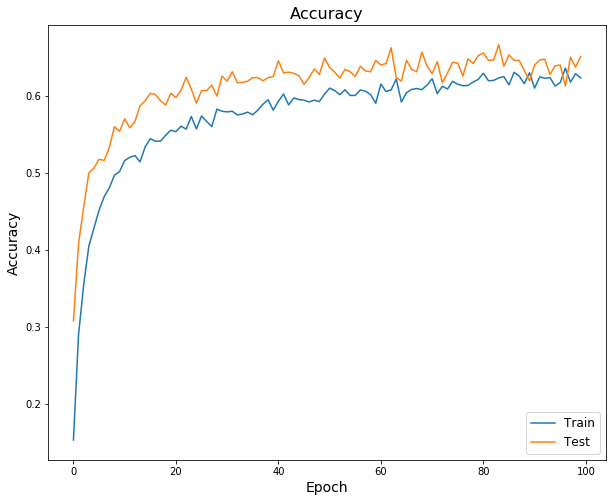

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10,8))
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Accuracy',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Test'], loc='lower right', fontsize = 12)
plt.show()



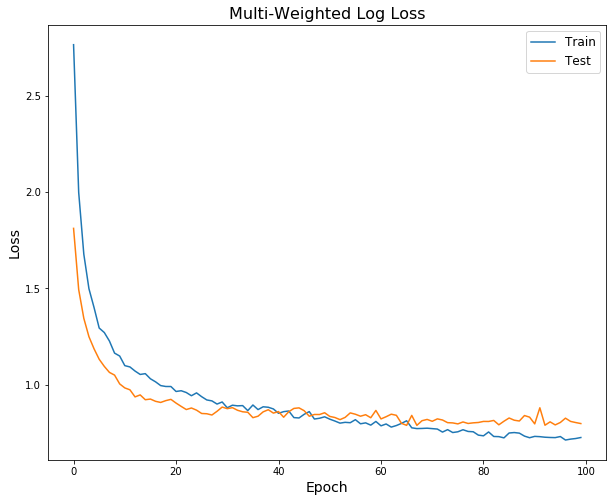

In [20]:
plt.figure(figsize= (10,8))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Multi-Weighted Log Loss',fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch',fontsize = 14)
plt.legend(['Train', 'Test'], loc='upper right',fontsize = 12)
plt.show()